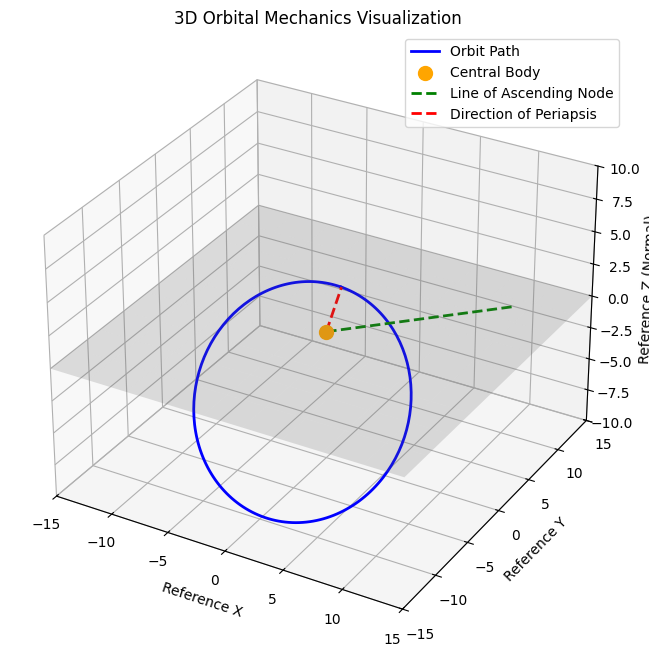

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_orbital_elements():
    # Orbital parameters for visualization
    a = 10.0          # Semi-major axis
    e = 0.6           # Eccentricity
    i = np.radians(30) # Inclination
    Omega = np.radians(45) # Longitude of Ascending Node
    omega = np.radians(60) # Argument of Periapsis

    # Generate eccentric anomaly values
    E = np.linspace(0, 2 * np.pi, 200)

    # Coordinates in the orbital plane (x', y', z')
    x_prime = a * (np.cos(E) - e)
    y_prime = a * np.sqrt(1 - e**2) * np.sin(E)
    z_prime = np.zeros_like(E)

    # Rotation matrices for 3D orientation
    # 1. Rotate by Argument of Periapsis (omega) around z-axis
    R_omega = np.array([[np.cos(omega), -np.sin(omega), 0],
                        [np.sin(omega),  np.cos(omega), 0],
                        [0,              0,             1]])

    # 2. Rotate by Inclination (i) around x-axis
    R_i = np.array([[1, 0,             0],
                    [0, np.cos(i), -np.sin(i)],
                    [0, np.sin(i),  np.cos(i)]])

    # 3. Rotate by Longitude of Ascending Node (Omega) around z-axis
    R_Omega = np.array([[np.cos(Omega), -np.sin(Omega), 0],
                        [np.sin(Omega),  np.cos(Omega), 0],
                        [0,              0,             1]])

    # Combined rotation matrix
    R_total = R_Omega @ R_i @ R_omega

    # Apply rotations to orbital plane coordinates
    orbit_coords = np.array([x_prime, y_prime, z_prime])
    orbit_3d = R_total @ orbit_coords

    # Set up the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the orbit
    ax.plot(orbit_3d[0], orbit_3d[1], orbit_3d[2], 'b-', linewidth=2, label='Orbit Path')

    # Plot central body
    ax.scatter([0], [0], [0], color='orange', s=100, label='Central Body')

    # Define and plot the Reference Plane (xy-plane)
    xx, yy = np.meshgrid(np.linspace(-15, 15, 10), np.linspace(-15, 15, 10))
    zz = np.zeros_like(xx)
    ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

    # Calculate Line of Nodes vector (intersects reference plane)
    node_x = np.cos(Omega) * 15
    node_y = np.sin(Omega) * 15
    ax.plot([0, node_x], [0, node_y], [0, 0], 'g--', linewidth=2, label='Line of Ascending Node')

    # Calculate Periapsis vector
    periapsis_prime = np.array([a * (1 - e), 0, 0])
    periapsis_3d = R_total @ periapsis_prime
    ax.plot([0, periapsis_3d[0]], [0, periapsis_3d[1]], [0, periapsis_3d[2]], 'r--', linewidth=2, label='Direction of Periapsis')

    # Set labels and view
    ax.set_xlabel('Reference X')
    ax.set_ylabel('Reference Y')
    ax.set_zlabel('Reference Z (Normal)')
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-10, 10])
    ax.legend()
    ax.set_title("3D Orbital Mechanics Visualization")

    plt.show()

plot_orbital_elements()

--- R.O.M. DEGENERACY RESOLUTION TEST ---
Target Beta: 0.05
Target Inclination: 60.00°

Optimizing based strictly on Z_sys scalar baseline decoupling...

--- RECOVERY RESULTS ---
Recovered Beta: 0.05000000 (Error: 1.02e-14)
Recovered Inclination: 60.0000° (Error: 2.43e-11°)

Max Systemic Shift (Z_sys baseline): 1.005929
Required spectrographic resolution to break degeneracy: ΔZ ~ 5.93e-03


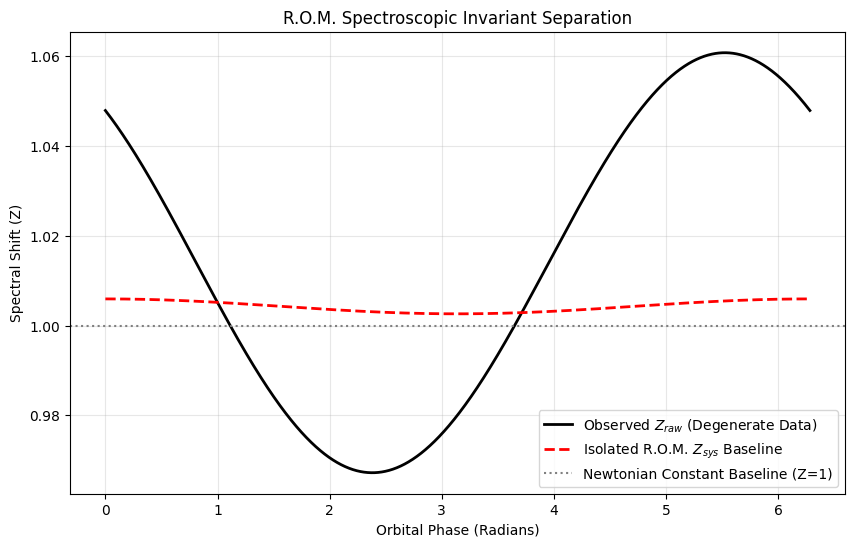

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# 1. R.O.M. THEORETICAL FORWARD MODEL
# ==========================================
def generate_z_raw(o, beta, i_inc, e, omega):
    """
    Calculates the exact raw spectral shift Z_raw(o) according to R.O.M. geometry.
    """
    # 1. Line-of-sight velocity projection (Directional)
    K = (beta / np.sqrt(1 - e**2)) * np.sin(i_inc)
    beta_los = K * (np.cos(o + omega) + e * np.cos(omega))

    # 2. Local squared projections (Scalar Invariants)
    beta_o_sq = (beta**2) * (1 + e**2 + 2 * e * np.cos(o)) / (1 - e**2)
    kappa_o_sq = 2 * (beta**2) * (1 + e * np.cos(o)) / (1 - e**2)

    # 3. Systemic invariant baseline
    Z_sys = (1 - beta_o_sq)**(-0.5) * (1 - kappa_o_sq)**(-0.5)

    # 4. Total raw observation
    return Z_sys * (1 + beta_los)

# ==========================================
# 2. EXPERIMENT PARAMETERS (True State)
# ==========================================
# Testing with a highly relativistic system to make 2nd-order effects obvious
BETA_TRUE = 0.05       # 5% of c (Global kinetic projection)
I_INC_TRUE = np.radians(60) # 60 degree inclination
E_TRUE = 0.3           # Eccentricity
OMEGA_TRUE = np.radians(45) # Argument of periapsis

# Generate observation data
phases = np.linspace(0, 2 * np.pi, 2000)
z_raw_data = generate_z_raw(phases, BETA_TRUE, I_INC_TRUE, E_TRUE, OMEGA_TRUE)

# ==========================================
# 3. BLIND RECOVERY ALGORITHM
# ==========================================
def objective_function(params, o_data, z_data, e_known, omega_known):
    """
    Error function to minimize.
    params[0] = beta guess
    params[1] = inclination guess (radians)
    """
    beta_guess, i_guess = params

    # Constrain physical bounds
    if beta_guess <= 0 or beta_guess >= 1 / np.sqrt(3): # Q_t must be real
        return np.inf
    if i_guess <= 0 or i_guess >= np.pi:
        return np.inf

    z_model = generate_z_raw(o_data, beta_guess, i_guess, e_known, omega_known)

    # Return Sum of Squared Errors (SSE)
    return np.sum((z_data - z_model)**2)

# Initial classical degenerate guess (assumes random baseline)
# In classical mechanics, beta and i are fully degenerate.
# We feed the optimizer bad initial guesses to test if the R.O.M. invariants force convergence.
initial_guess = [0.01, np.radians(30)]

# Run the optimization
print("--- R.O.M. DEGENERACY RESOLUTION TEST ---")
print(f"Target Beta: {BETA_TRUE}")
print(f"Target Inclination: {np.degrees(I_INC_TRUE):.2f}°\n")
print("Optimizing based strictly on Z_sys scalar baseline decoupling...")

result = minimize(
    objective_function,
    initial_guess,
    args=(phases, z_raw_data, E_TRUE, OMEGA_TRUE),
    method='Nelder-Mead',
    options={'xatol': 1e-12, 'fatol': 1e-12, 'maxiter': 5000}
)

beta_recovered, i_recovered = result.x

# ==========================================
# 4. OUTPUT AND VERIFICATION
# ==========================================
print("\n--- RECOVERY RESULTS ---")
print(f"Recovered Beta: {beta_recovered:.8f} (Error: {abs(beta_recovered - BETA_TRUE):.2e})")
print(f"Recovered Inclination: {np.degrees(i_recovered):.4f}° (Error: {abs(np.degrees(i_recovered) - np.degrees(I_INC_TRUE)):.2e}°)")

# Calculate the magnitude of the 2nd-order effect (Peak precision required)
Z_sys_max = np.max(z_raw_data / (1 + (beta_recovered / np.sqrt(1 - E_TRUE**2)) * np.sin(i_recovered) * (np.cos(phases + OMEGA_TRUE) + E_TRUE * np.cos(OMEGA_TRUE))))
print(f"\nMax Systemic Shift (Z_sys baseline): {Z_sys_max:.6f}")
print(f"Required spectrographic resolution to break degeneracy: ΔZ ~ {abs(Z_sys_max - 1.0):.2e}")

# Plotting the separation
plt.figure(figsize=(10, 6))
plt.plot(phases, z_raw_data, label="Observed $Z_{raw}$ (Degenerate Data)", color="black", linewidth=2)

# Reconstruct isolated baseline
K_recovered = (beta_recovered / np.sqrt(1 - E_TRUE**2)) * np.sin(i_recovered)
beta_los_recovered = K_recovered * (np.cos(phases + OMEGA_TRUE) + E_TRUE * np.cos(OMEGA_TRUE))
z_sys_recovered = z_raw_data / (1 + beta_los_recovered)

plt.plot(phases, z_sys_recovered, label="Isolated R.O.M. $Z_{sys}$ Baseline", color="red", linestyle="--", linewidth=2)
plt.axhline(1.0, color='gray', linestyle=':', label="Newtonian Constant Baseline (Z=1)")
plt.title("R.O.M. Spectroscopic Invariant Separation")
plt.xlabel("Orbital Phase (Radians)")
plt.ylabel("Spectral Shift (Z)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Loading empirical dataset...
Successfully loaded and parsed 82 observational points.

Executing R.O.M. Inversion...

=== R.O.M. EMPIRICAL RECOVERY RESULTS ===
Global Kinetic Projection (β): 0.005731
Extracted Inclination (i): 128.08°
Fit Quality (χ²): 221.00


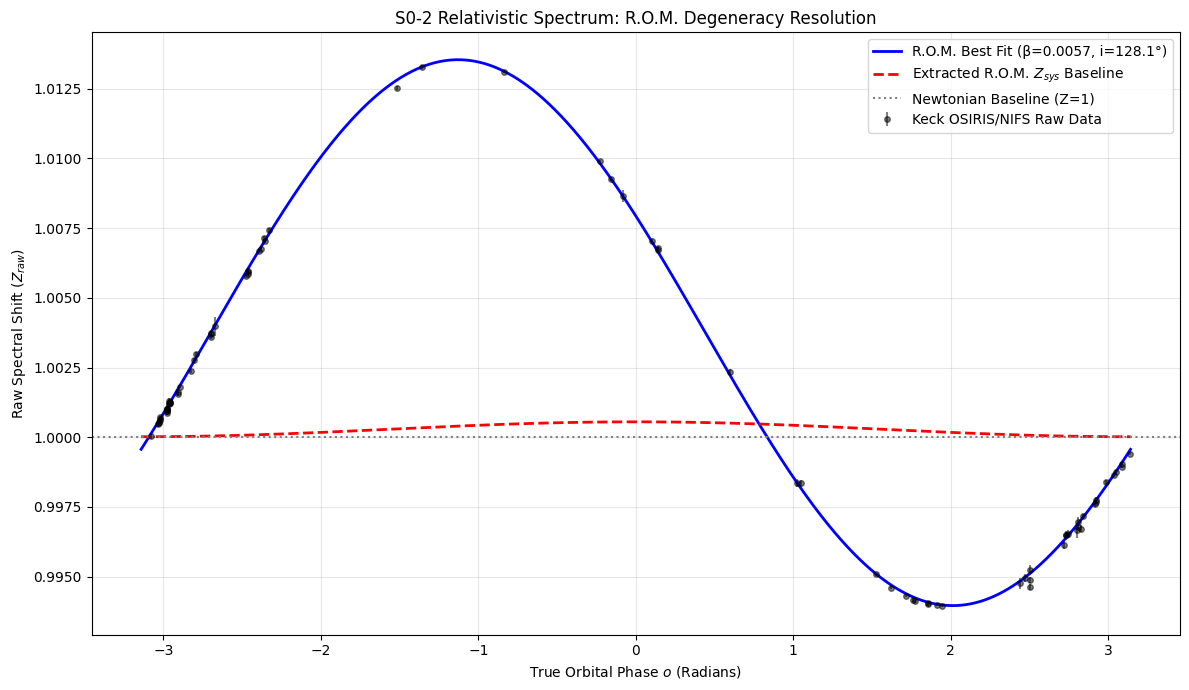

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# 1. FIXED SYSTEM PARAMETERS (S0-2 GRAVITY)
# ==========================================
C_KMS = 299792.458              # Speed of light in km/s
P_YRS = 16.0518                 # Orbital Period in years
P_DAYS = P_YRS * 365.25         # Orbital Period in days
E_FIXED = 0.88466               # Eccentricity
OMEGA_FIXED = np.radians(66.13) # Argument of periapsis (radians)
T_PERI = 58257.698              # Epoch of periapsis (MJD)

# ==========================================
# 2. KEPLER SOLVER (Time -> Phase Mapping)
# ==========================================
def get_phase(t, t_peri, P, e):
    """Converts observation epoch (MJD) to true orbital phase (o) in radians."""
    M = (2 * np.pi / P) * (t - t_peri)
    E = M.copy()
    # Newton-Raphson iteration for exact Kepler equation solution
    for _ in range(20):
        E = E - (E - e * np.sin(E) - M) / (1 - e * np.cos(E))

    # Calculate true anomaly (phase o)
    o = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))
    return o

# ==========================================
# 3. R.O.M. EXACT OBSERVATIONAL MODEL
# ==========================================
def generate_z_raw(o, beta, i_inc, e, omega):
    """Calculates the exact theoretical Z_raw at phase o using R.O.M."""
    # Directional Line-of-Sight Kinematic Projection
    K = (beta / np.sqrt(1 - e**2)) * np.sin(i_inc)
    beta_los = K * (np.cos(o + omega) + e * np.cos(omega))

    # Local Squared Projections (Scalar Invariants)
    beta_o_sq = (beta**2) * (1 + e**2 + 2 * e * np.cos(o)) / (1 - e**2)
    kappa_o_sq = 2 * (beta**2) * (1 + e * np.cos(o)) / (1 - e**2)

    # Systemic Phase Factor Z_sys (2nd-Order Baseline)
    Z_sys = (1 - beta_o_sq)**(-0.5) * (1 - kappa_o_sq)**(-0.5)

    return Z_sys * (1 + beta_los)

# ==========================================
# 4. DATA PARSING & PREPARATION
# ==========================================
print("Loading empirical dataset...")
try:
    df = pd.read_csv('/content/S0-2_DataS1_full.csv')
    df.columns = df.columns.str.strip() # Clean whitespace from headers

    t_obs = df['MJD'].values
    # Corrected column name from 'vz_km_s' to 'RV_km_s'
    vz_obs = df['RV_km_s'].values
    sigma_vz = df['sigma_km_s'].values

    # Convert velocity to purely relational spectral shift (Z)
    Z_obs = 1.0 + (vz_obs / C_KMS)
    sigma_Z = sigma_vz / C_KMS

    # Map time epochs to true orbital phase
    o_obs = get_phase(t_obs, T_PERI, P_DAYS, E_FIXED)
    print(f"Successfully loaded and parsed {len(Z_obs)} observational points.")

except Exception as e:
    print(f"DATA ERROR: Ensure 'S0-2_DataS1_full.csv' is uploaded and column names match. Details: {e}")
    raise

# ==========================================
# 5. CHI-SQUARED OPTIMIZATION (BLIND INVERSION)
# ==========================================
def objective_function(params):
    beta_guess, i_guess = params

    # Physical boundaries logic
    if beta_guess <= 0 or beta_guess >= 1/np.sqrt(3):
        return np.inf
    if i_guess <= 0 or i_guess >= np.pi:
        return np.inf

    # Generate model with current parameters
    Z_model = generate_z_raw(o_obs, beta_guess, i_guess, E_FIXED, OMEGA_FIXED)

    # Calculate Chi-Squared (weighted by instrumental precision)
    chi2 = np.sum(((Z_obs - Z_model) / sigma_Z)**2)
    return chi2

# Initial approximation (beta ~ peak velocity / c, random i)
initial_guess = [0.015, np.radians(100)]

print("\nExecuting R.O.M. Inversion...")
result = minimize(
    objective_function,
    initial_guess,
    method='Nelder-Mead',
    options={'xatol': 1e-10, 'fatol': 1e-10, 'maxiter': 10000}
)

beta_opt, i_opt = result.x

# Fix inclination quadrant if necessary (symmetry of sine)
i_deg = np.degrees(i_opt)
if i_deg > 180:
    i_deg = i_deg % 180

# ==========================================
# 6. RESULTS OUTPUT & VISUALIZATION
# ==========================================
print("\n=== R.O.M. EMPIRICAL RECOVERY RESULTS ===")
print(f"Global Kinetic Projection (β): {beta_opt:.6f}")
print(f"Extracted Inclination (i): {i_deg:.2f}°")
print(f"Fit Quality (χ²): {result.fun:.2f}")

# Reconstruct the continuous theoretical curves for plotting
o_continuous = np.linspace(-np.pi, np.pi, 2000)
Z_model_continuous = generate_z_raw(o_continuous, beta_opt, i_opt, E_FIXED, OMEGA_FIXED)

# Isolate the extracted Z_sys baseline
beta_o_sq_c = (beta_opt**2) * (1 + E_FIXED**2 + 2 * E_FIXED * np.cos(o_continuous)) / (1 - E_FIXED**2)
kappa_o_sq_c = 2 * (beta_opt**2) * (1 + E_FIXED * np.cos(o_continuous)) / (1 - E_FIXED**2)
Z_sys_continuous = (1 - beta_o_sq_c)**(-0.5) * (1 - kappa_o_sq_c)**(-0.5)

# Plotting
plt.figure(figsize=(12, 7))
plt.errorbar(o_obs, Z_obs, yerr=sigma_Z, fmt='o', color='black', alpha=0.5, label="Keck OSIRIS/NIFS Raw Data", markersize=4)
plt.plot(o_continuous, Z_model_continuous, color='blue', linewidth=2, label=f"R.O.M. Best Fit (β={beta_opt:.4f}, i={i_deg:.1f}°)")
plt.plot(o_continuous, Z_sys_continuous, color='red', linestyle='--', linewidth=2, label="Extracted R.O.M. $Z_{sys}$ Baseline")
plt.axhline(1.0, color='gray', linestyle=':', label="Newtonian Baseline (Z=1)")

plt.title("S0-2 Relativistic Spectrum: R.O.M. Degeneracy Resolution")
plt.xlabel("True Orbital Phase $o$ (Radians)")
plt.ylabel("Raw Spectral Shift ($Z_{raw}$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

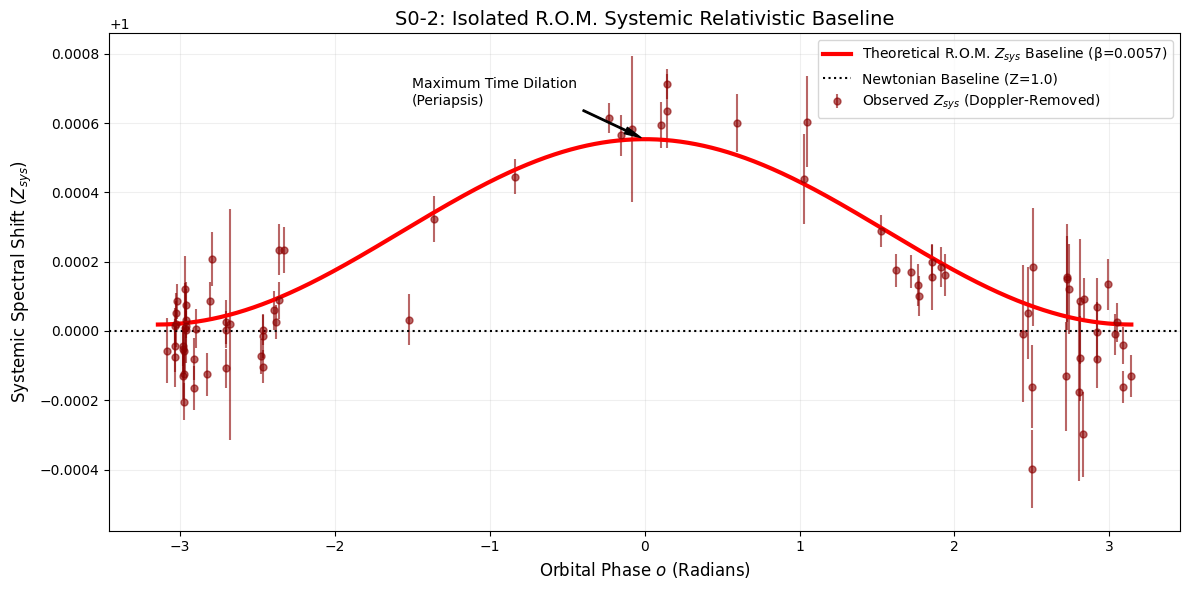

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Isolate the Z_sys (systemic shift) from the observed data
# We do this by dividing the observed Z by the recovered Doppler term (1 + beta_los)
K_opt = (beta_opt / np.sqrt(1 - E_FIXED**2)) * np.sin(i_opt)
beta_los_obs = K_opt * (np.cos(o_obs + OMEGA_FIXED) + E_FIXED * np.cos(OMEGA_FIXED))
Z_sys_obs = Z_obs / (1 + beta_los_obs)

# 2. Create the visualization
plt.figure(figsize=(12, 6))

# Plot the individual data points (cleaned of 1st order Doppler)
plt.errorbar(o_obs, Z_sys_obs, yerr=sigma_Z, fmt='o', color='darkred', alpha=0.6,
             label='Observed $Z_{sys}$ (Doppler-Removed)', markersize=5)

# Plot the continuous theoretical R.O.M. baseline
plt.plot(o_continuous, Z_sys_continuous, color='red', linewidth=3,
         label=f'Theoretical R.O.M. $Z_{{sys}}$ Baseline (β={beta_opt:.4f})')

# Reference line for Newtonian physics (where Z_sys would always be 1.0)
plt.axhline(1.0, color='black', linestyle=':', label='Newtonian Baseline (Z=1.0)')

plt.title("S0-2: Isolated R.O.M. Systemic Relativistic Baseline", fontsize=14)
plt.xlabel("Orbital Phase $o$ (Radians)", fontsize=12)
plt.ylabel("Systemic Spectral Shift ($Z_{sys}$)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)

# Annotate the peak (Periapsis passage effect)
peak_idx = np.argmax(Z_sys_continuous)
plt.annotate('Maximum Time Dilation\n(Periapsis)',
             xy=(o_continuous[peak_idx], Z_sys_continuous[peak_idx]),
             xytext=(o_continuous[peak_idx]-1.5, Z_sys_continuous[peak_idx]+0.0001),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# 1. FIXED SYSTEM PARAMETERS (S0-2 GRAVITY)
# ==========================================
C_KMS = 299792.458              # Speed of light in km/s
P_YRS = 16.0518                 # Orbital Period in years
P_DAYS = P_YRS * 365.25         # Orbital Period in days
E_FIXED = 0.88466               # Eccentricity
OMEGA_FIXED = np.radians(66.13) # Argument of periapsis (radians)
T_PERI = 58257.698              # Epoch of periapsis (MJD)

# ==========================================
# 2. KEPLER SOLVER (Time -> Phase Mapping)
# ==========================================
def get_phase(t, t_peri, P, e):
    """Converts observation epoch (MJD) to true orbital phase (o) in radians."""
    M = (2 * np.pi / P) * (t - t_peri)
    E = M.copy()
    for _ in range(20):
        E = E - (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
    o = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))
    return o

# ==========================================
# 3. R.O.M. EXACT OBSERVATIONAL MODEL
# ==========================================
def generate_z_raw(o, beta, i_inc, beta_z0, e, omega):
    """Calculates Z_raw incorporating ROM geometry and background drift."""
    # Directional Line-of-Sight Kinematic Projection
    K = (beta / np.sqrt(1 - e**2)) * np.sin(i_inc)
    beta_los = K * (np.cos(o + omega) + e * np.cos(omega))

    # Local Squared Projections (Scalar Invariants)
    beta_o_sq = (beta**2) * (1 + e**2 + 2 * e * np.cos(o)) / (1 - e**2)
    kappa_o_sq = 2 * (beta**2) * (1 + e * np.cos(o)) / (1 - e**2)

    # Systemic Phase Factor Z_sys (2nd-Order Baseline)
    Z_sys = (1 - beta_o_sq)**(-0.5) * (1 - kappa_o_sq)**(-0.5)

    # Total combined observed shift
    return Z_sys * (1 + beta_los) * (1 + beta_z0)

# ==========================================
# 4. DATA PARSING & PREPARATION
# ==========================================
print("Loading empirical dataset...")
df = pd.read_csv('S0-2_DataS1_full.csv')
df.columns = df.columns.str.strip()

t_obs = df['MJD'].values
vz_obs = df['RV_km_s'].values
sigma_vz = df['sigma_km_s'].values

# Convert to Z-shift
Z_obs = 1.0 + (vz_obs / C_KMS)
sigma_Z = sigma_vz / C_KMS

o_obs = get_phase(t_obs, T_PERI, P_DAYS, E_FIXED)
print(f"Successfully loaded {len(Z_obs)} points.")

# ==========================================
# 5. CHI-SQUARED OPTIMIZATION (3 PARAMETERS)
# ==========================================
def objective_function(params):
    beta_guess, i_guess, beta_z0_guess = params

    if beta_guess <= 0 or beta_guess >= 1/np.sqrt(3):
        return np.inf
    if i_guess <= 0 or i_guess >= np.pi:
        return np.inf

    Z_model = generate_z_raw(o_obs, beta_guess, i_guess, beta_z0_guess, E_FIXED, OMEGA_FIXED)
    chi2 = np.sum(((Z_obs - Z_model) / sigma_Z)**2)
    return chi2

# Initial guesses: beta ~ peak/c, i ~ 90 deg, drift ~ 0 km/s
initial_guess = [0.015, np.radians(90), 0.0]

print("\nExecuting R.O.M. 3-Parameter Inversion...")
result = minimize(
    objective_function,
    initial_guess,
    method='Nelder-Mead',
    options={'xatol': 1e-11, 'fatol': 1e-11, 'maxiter': 15000}
)

beta_opt, i_opt, beta_z0_opt = result.x

i_deg = np.degrees(i_opt)
if i_deg > 180:
    i_deg = i_deg % 180

vz0_kms = beta_z0_opt * C_KMS

# ==========================================
# 6. RESULTS OUTPUT
# ==========================================
print("\n=== R.O.M. 3-PARAMETER RECOVERY RESULTS ===")
print(f"Global Kinetic Projection (\u03B2): {beta_opt:.6f}")
print(f"Extracted Inclination (i): {i_deg:.2f}\u00B0")
print(f"System Background Drift (v_z0): {vz0_kms:.2f} km/s")
print(f"Fit Quality (\u03C7\u00B2): {result.fun:.2f}")

Loading empirical dataset...
Successfully loaded 82 points.

Executing R.O.M. 3-Parameter Inversion...

=== R.O.M. 3-PARAMETER RECOVERY RESULTS ===
Global Kinetic Projection (β): 0.006254
Extracted Inclination (i): 133.79°
System Background Drift (v_z0): -20.52 km/s
Fit Quality (χ²): 167.70


<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:34: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3089133375.py:34: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f"S0-2: Isolated R.O.M. Systemic Baseline (3-Parameter Fit)\nExtracted $i={np.degrees(i_opt):.2f}^\circ$, $v_{{z0}}={beta_z0_opt * C_KMS:.2f}$ km/s", fontsize=14)


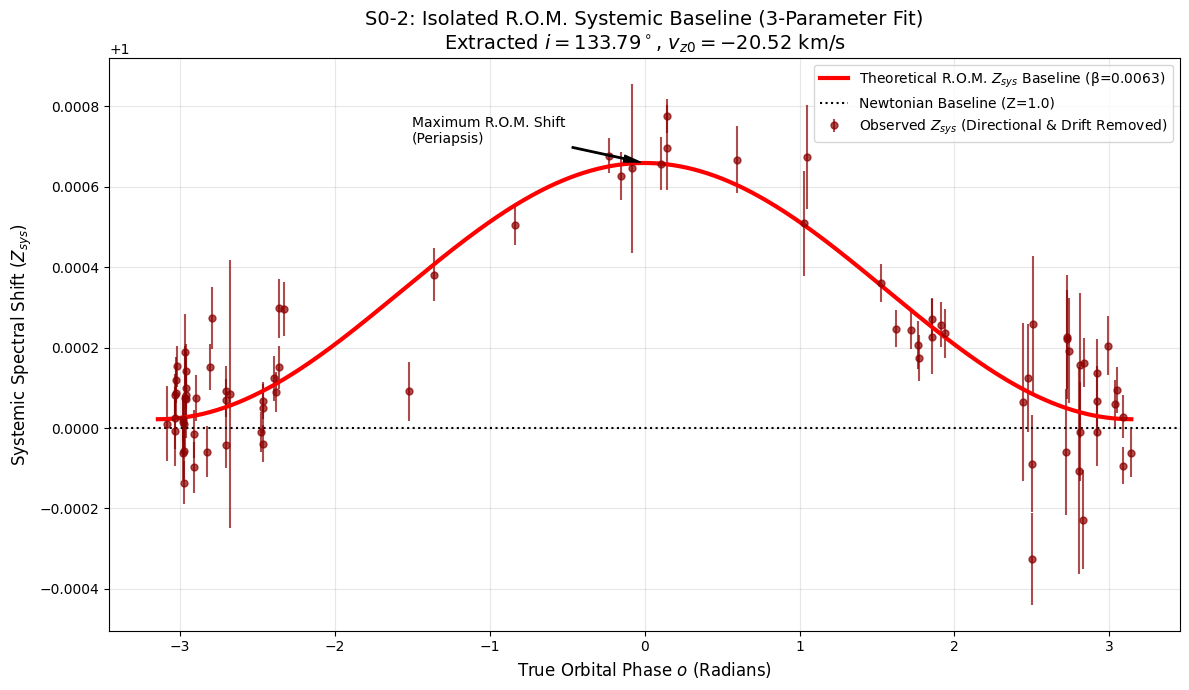

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Isolate the Z_sys (systemic shift) from the observed data
# We divide the observed Z by both the recovered directional Doppler term and the background drift
K_opt = (beta_opt / np.sqrt(1 - E_FIXED**2)) * np.sin(i_opt)
beta_los_obs = K_opt * (np.cos(o_obs + OMEGA_FIXED) + E_FIXED * np.cos(OMEGA_FIXED))

# Isolated observed systemic baseline
Z_sys_obs = Z_obs / ((1 + beta_los_obs) * (1 + beta_z0_opt))

# 2. Reconstruct the continuous theoretical curves for plotting
o_continuous = np.linspace(-np.pi, np.pi, 2000)
beta_o_sq_c = (beta_opt**2) * (1 + E_FIXED**2 + 2 * E_FIXED * np.cos(o_continuous)) / (1 - E_FIXED**2)
kappa_o_sq_c = 2 * (beta_opt**2) * (1 + E_FIXED * np.cos(o_continuous)) / (1 - E_FIXED**2)

Z_sys_continuous = (1 - beta_o_sq_c)**(-0.5) * (1 - kappa_o_sq_c)**(-0.5)

# 3. Create the visualization
plt.figure(figsize=(12, 7))

# Plot the individual empirical data points (cleaned of 1st order Doppler and background drift)
plt.errorbar(o_obs, Z_sys_obs, yerr=sigma_Z, fmt='o', color='darkred', alpha=0.7,
             label='Observed $Z_{sys}$ (Directional & Drift Removed)', markersize=5)

# Plot the continuous theoretical R.O.M. baseline
plt.plot(o_continuous, Z_sys_continuous, color='red', linewidth=3,
         label=f'Theoretical R.O.M. $Z_{{sys}}$ Baseline (\u03B2={beta_opt:.4f})')

# Reference line for Newtonian physics (where Z_sys would always be exactly 1.0)
plt.axhline(1.0, color='black', linestyle=':', label='Newtonian Baseline (Z=1.0)')

# Title and labels mapping the extracted parameters
plt.title(f"S0-2: Isolated R.O.M. Systemic Baseline (3-Parameter Fit)\nExtracted $i={np.degrees(i_opt):.2f}^\circ$, $v_{{z0}}={beta_z0_opt * C_KMS:.2f}$ km/s", fontsize=14)
plt.xlabel("True Orbital Phase $o$ (Radians)", fontsize=12)
plt.ylabel("Systemic Spectral Shift ($Z_{sys}$)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Annotate the peak (Periapsis passage effect where kinetic and potential projections are maximized)
peak_idx = np.argmax(Z_sys_continuous)
plt.annotate('Maximum R.O.M. Shift\n(Periapsis)',
             xy=(o_continuous[peak_idx], Z_sys_continuous[peak_idx]),
             xytext=(o_continuous[peak_idx]-1.5, Z_sys_continuous[peak_idx]+0.00005),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

plt.tight_layout()
plt.show()